# Reward Estimator Training

This notebook trains a model to predict the reward associated with a given
state (represented by the current image frame).
It uses the reward labels generated interactively via `reward_labeling.ipynb`.


In [1]:
# Basic Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import copy # For saving best model
from models import SimpleRewardEstimator
# Project specific imports - ensure these files are accessible
import config
from importnb import Notebook
with Notebook():
    from jetbot_dataset import JetbotDataset
    from reward_dataset import RewardDatasetSingleFrame

print(f"Using device: {config.DEVICE}")
print(f"Reward labels expected at: {config.MANUAL_COLLECTED_REWARD_CSV}") # Use the path from config
print(f"Main data CSV: {config.CSV_PATH}")
print(f"Main data dir: {config.DATA_DIR}")

Using device: cuda
Reward labels expected at: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_data\interactive_reward_labels_subset.csv
Main data CSV: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_data\data.csv
Main data dir: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_data


## Configuration
Define training hyperparameters. Some can be reused from `config.py`.

In [ ]:
N_FRAMES          = 4                     # prev frames to stack (plus the current)
BATCH_SIZE        = 64
LR                = 3e-4
EPOCHS            = 20
IMG_SIZE          = 96                    # matches world-model training
CHECKPOINT_DIR    = Path("outputs/reward_estimator_resnet")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
DEVICE            = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
REWARD_BATCH_SIZE = 16        # Can be different from diffusion model batch size
REWARD_LEARNING_RATE = 1e-4
REWARD_NUM_EPOCHS = 50
REWARD_VALIDATION_SPLIT = 0.1 # Percentage of labeled data to use for validation
REWARD_SEED = 42             # For reproducible train/val split
REWARD_MODEL_OUTPUT_DIR = os.path.join(config.OUTPUT_DIR, 'reward_estimator')
REWARD_CHECKPOINT_FILENAME = "reward_estimator_best.pth"

# Ensure output directory exists
os.makedirs(REWARD_MODEL_OUTPUT_DIR, exist_ok=True)

# --- Data Loading Parameters (from config.py) ---
IMAGE_SIZE = config.IMAGE_SIZE
REWARD_CSV_PATH = config.MANUAL_COLLECTED_REWARD_CSV # Path to the labels
MAIN_CSV_PATH = config.CSV_PATH
MAIN_DATA_DIR = config.DATA_DIR
TRANSFORM = config.TRANSFORM # Use the same transform as the diffusion model for consistency



## Reward Estimator Model Definition
Uses a CNN architecture. This is a simple example; you might need a more complex model depending on performance. It takes the concatenated image sequence as input.

In [3]:
reward_model = SimpleRewardEstimator()
print("Reward Estimator Model Architecture (Single Frame Input):")
print(reward_model)

# Move model to device
reward_model.to(config.DEVICE)

Reward Estimator Model Architecture (Single Frame Input):
SimpleRewardEstimator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2)

SimpleRewardEstimator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_feature

## Data Loading and Splitting
Instantiate the dataset and create DataLoaders for training and validation.


In [3]:
# Instantiate the dataset
try:
    # MODIFIED: Using RewardDatasetSingleFrame
    reward_dataset = RewardDatasetSingleFrame(
        main_csv_path=MAIN_CSV_PATH,
        reward_csv_path=REWARD_CSV_PATH,
        data_dir=MAIN_DATA_DIR,
        image_size=IMAGE_SIZE,
        transform=TRANSFORM
    )
except Exception as e:
    print(f"Failed to instantiate RewardDatasetSingleFrame: {e}")
    reward_dataset = None # Set to None to prevent further errors

if reward_dataset and len(reward_dataset) > 0:
    # Split into training and validation sets
    total_size = len(reward_dataset)
    val_size = int(REWARD_VALIDATION_SPLIT * total_size)
    train_size = total_size - val_size

    # Ensure sizes are valid
    if train_size <= 0 or val_size <=0:
        print(f"Warning: Dataset size ({total_size}) is too small for validation split ({REWARD_VALIDATION_SPLIT}). Using full dataset for training.")
        train_subset = reward_dataset
        val_loader = None # No validation
    else:
        print(f"Splitting dataset: Train size = {train_size}, Validation size = {val_size}")
        # Use torch.manual_seed for reproducible splits
        torch.manual_seed(REWARD_SEED)
        train_subset, val_subset = random_split(reward_dataset, [train_size, val_size])
        # Create Validation Loader only if val_size > 0
        val_loader = DataLoader(
            val_subset,
            batch_size=REWARD_BATCH_SIZE,
            shuffle=False, # No need to shuffle validation set
            num_workers=0,
            pin_memory=True
        )


    # Create Training Loader
    train_loader = DataLoader(
        train_subset,
        batch_size=REWARD_BATCH_SIZE,
        shuffle=True,
        num_workers=0, # Adjust based on your system
        pin_memory=True
    )


    print("DataLoaders created.")
    # Optional: Display a sample batch
    try:
       sample_batch = next(iter(train_loader))
       print("Sample batch - Input shape:", sample_batch[0].shape)
       print("Sample batch - Reward shape:", sample_batch[1].shape)
    except Exception as e:
        print(f"Could not load a sample batch: {e}")

else:
    print("Skipping DataLoader creation as dataset is empty or failed to load.")
    train_loader = None
    val_loader = None




Loaded main data CSV: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_data\data.csv (23081 rows)
Loaded reward labels CSV: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_data\interactive_reward_labels_subset.csv (45 rows)
Created labeled dataframe with 45 entries.
Dataset length: 45
Splitting dataset: Train size = 41, Validation size = 4
DataLoaders created.
Could not load a sample batch: name 'os' is not defined


In [7]:
pd

<module 'pandas' from 'C:\\Projects\\pythonenv-deeprl\\Lib\\site-packages\\pandas\\__init__.py'>

## Training Setup
Define the loss function and optimizer.


In [9]:

if reward_dataset and len(reward_dataset) > 0:
    # Loss Function (Mean Squared Error is common for regression)
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(reward_model.parameters(), lr=REWARD_LEARNING_RATE)

    print("Loss function and optimizer defined.")
else:
    print("Skipping training setup.")
    criterion = None
    optimizer = None


Loss function and optimizer defined.


## Training Loop

In [10]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

# MODIFIED: Check train_loader exists, val_loader is optional now
if train_loader and criterion and optimizer:
    print("Starting training...")
    for epoch in range(REWARD_NUM_EPOCHS):
        # --- Training Phase ---
        reward_model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{REWARD_NUM_EPOCHS} [Train]", leave=False)

        # MODIFIED: Unpack only image and reward
        for i, (images, rewards) in enumerate(train_pbar):
            images = images.to(config.DEVICE)
            rewards = rewards.to(config.DEVICE)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            # MODIFIED: Pass only images to the model
            predicted_rewards = reward_model(images)

            # Calculate loss
            loss = criterion(predicted_rewards, rewards)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_pbar.close()

        # --- Validation Phase (Optional) ---
        epoch_val_loss = None
        if val_loader: # Only run validation if val_loader exists
            reward_model.eval()
            running_val_loss = 0.0
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{REWARD_NUM_EPOCHS} [Val]", leave=False)

            with torch.no_grad():
                 # MODIFIED: Unpack only image and reward
                for images, rewards in val_pbar:
                    images = images.to(config.DEVICE)
                    rewards = rewards.to(config.DEVICE)

                    # MODIFIED: Pass only images to the model
                    predicted_rewards = reward_model(images)
                    loss = criterion(predicted_rewards, rewards)
                    running_val_loss += loss.item()
                    val_pbar.set_postfix({'loss': loss.item()})

            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)
            val_pbar.close()

            print(f"Epoch {epoch+1}/{REWARD_NUM_EPOCHS} - Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

            # --- Save Best Model ---
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model_state = copy.deepcopy(reward_model.state_dict())
                print(f"  -> New best model saved with validation loss: {best_val_loss:.6f}")
                checkpoint_path = os.path.join(REWARD_MODEL_OUTPUT_DIR, REWARD_CHECKPOINT_FILENAME)
                torch.save(best_model_state, checkpoint_path)
                print(f"  -> Best model state saved to {checkpoint_path}")
        else:
             # If no validation, just print training loss
             print(f"Epoch {epoch+1}/{REWARD_NUM_EPOCHS} - Train Loss: {epoch_train_loss:.6f}")
             # Optionally save based on training loss improvement or just save periodically/last
             # Example: Saving based on training loss (less common than validation)
             # if epoch_train_loss < best_val_loss: # Using best_val_loss variable name but tracking train loss
             #     best_val_loss = epoch_train_loss
             #     best_model_state = copy.deepcopy(reward_model.state_dict())
             #     checkpoint_path = os.path.join(REWARD_MODEL_OUTPUT_DIR, REWARD_CHECKPOINT_FILENAME)
             #     torch.save(best_model_state, checkpoint_path)
             #     print(f"  -> Model state saved with training loss: {best_val_loss:.6f} to {checkpoint_path}")


    print("Training finished.")

    # --- Save the final model state ---
    final_checkpoint_path = os.path.join(REWARD_MODEL_OUTPUT_DIR, "reward_estimator_single_frame_final.pth")
    torch.save(reward_model.state_dict(), final_checkpoint_path)
    print(f"Final model state saved to {final_checkpoint_path}")

    # Also save the best model if validation was not used (will be the last state saved based on training loss if that logic was enabled)
    if not val_loader and best_model_state:
         checkpoint_path = os.path.join(REWARD_MODEL_OUTPUT_DIR, REWARD_CHECKPOINT_FILENAME)
         torch.save(best_model_state, checkpoint_path)
         print(f"Final 'best' model state based on training saved to {checkpoint_path}")


else:
    print("Training skipped due to issues in data loading or setup.")


Starting training...


Epoch 1/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.054247, Val Loss: 0.009845
  -> New best model saved with validation loss: 0.009845
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 2/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.025380, Val Loss: 0.008775
  -> New best model saved with validation loss: 0.008775
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 3/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.021078, Val Loss: 0.006260
  -> New best model saved with validation loss: 0.006260
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 4/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.017601, Val Loss: 0.004700
  -> New best model saved with validation loss: 0.004700
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 5/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.015067, Val Loss: 0.004237
  -> New best model saved with validation loss: 0.004237
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 6/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.014240, Val Loss: 0.004418


Epoch 7/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.012028, Val Loss: 0.003578
  -> New best model saved with validation loss: 0.003578
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 8/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.011583, Val Loss: 0.003945


Epoch 9/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.011907, Val Loss: 0.004036


Epoch 10/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.010521, Val Loss: 0.004676


Epoch 11/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.010471, Val Loss: 0.004105


Epoch 12/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.009995, Val Loss: 0.003170
  -> New best model saved with validation loss: 0.003170
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 13/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.010057, Val Loss: 0.004351


Epoch 14/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.009200, Val Loss: 0.004819


Epoch 15/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.008822, Val Loss: 0.004410


Epoch 16/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.009039, Val Loss: 0.004147


Epoch 17/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.008503, Val Loss: 0.004360


Epoch 18/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.008439, Val Loss: 0.003944


Epoch 19/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.008379, Val Loss: 0.003132
  -> New best model saved with validation loss: 0.003132
  -> Best model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth


Epoch 20/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.008865, Val Loss: 0.003318


Epoch 21/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.008544, Val Loss: 0.003953


Epoch 22/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.007763, Val Loss: 0.003305


Epoch 23/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 0.007963, Val Loss: 0.004768


Epoch 24/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.007350, Val Loss: 0.004496


Epoch 25/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.007537, Val Loss: 0.003643


Epoch 26/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.006845, Val Loss: 0.003392


Epoch 27/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.007618, Val Loss: 0.004919


Epoch 28/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 0.007522, Val Loss: 0.003795


Epoch 29/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 0.007236, Val Loss: 0.004541


Epoch 30/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.007789, Val Loss: 0.004613


Epoch 31/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 0.006699, Val Loss: 0.004124


Epoch 32/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 0.007080, Val Loss: 0.003702


Epoch 33/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 0.005845, Val Loss: 0.003572


Epoch 34/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 0.006359, Val Loss: 0.005422


Epoch 35/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 0.006873, Val Loss: 0.004054


Epoch 36/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.006155, Val Loss: 0.003938


Epoch 37/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.006028, Val Loss: 0.003334


Epoch 38/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.006057, Val Loss: 0.003552


Epoch 39/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.005833, Val Loss: 0.004215


Epoch 40/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.005258, Val Loss: 0.004549


Epoch 41/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 0.005779, Val Loss: 0.004768


Epoch 42/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.005636, Val Loss: 0.005609


Epoch 43/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.006175, Val Loss: 0.004157


Epoch 44/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.005582, Val Loss: 0.005186


Epoch 45/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.005271, Val Loss: 0.003716


Epoch 46/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.005760, Val Loss: 0.004117


Epoch 47/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.004780, Val Loss: 0.003764


Epoch 48/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.004865, Val Loss: 0.004210


Epoch 49/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.004736, Val Loss: 0.004409


Epoch 50/50 [Train]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.005056, Val Loss: 0.003564
Training finished.
Final model state saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_single_frame_final.pth


## Plotting Results 

Loss plot saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_training_loss_plot_single_frame.png


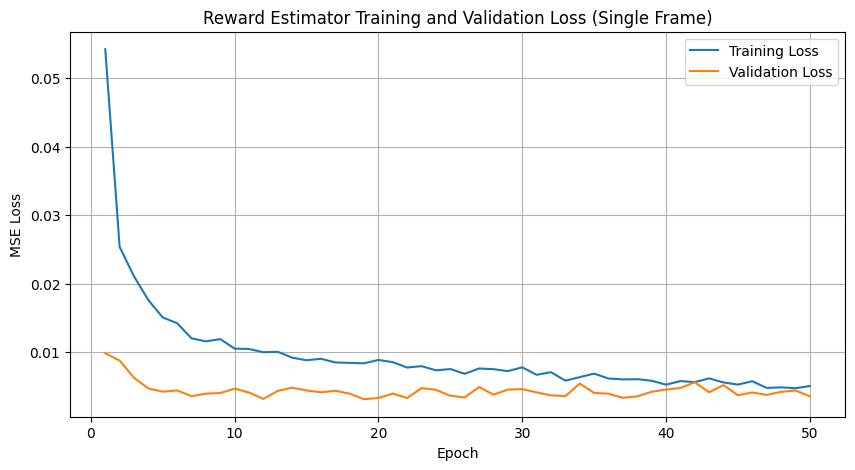

In [11]:
plt.figure(figsize=(10, 5))
if train_losses:
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
if val_losses:
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

# Add labels/title only if something was plotted
if train_losses or val_losses:
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Reward Estimator Training and Validation Loss (Single Frame)')
    plt.legend()
    plt.grid(True)
    plot_save_path = os.path.join(REWARD_MODEL_OUTPUT_DIR, 'reward_training_loss_plot_single_frame.png')
    plt.savefig(plot_save_path)
    print(f"Loss plot saved to {plot_save_path}")
    plt.show()
else:
    print("No training data to plot.")